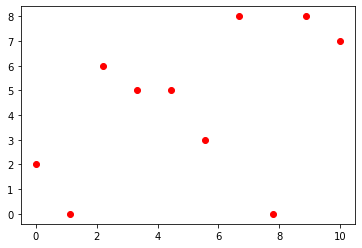

In [1]:
import numpy as np
from numpy import random
from scipy.interpolate import barycentric_interpolate
from scipy.interpolate import pchip_interpolate
from scipy.interpolate import krogh_interpolate
import matplotlib.pyplot as plt

x_observed = np.linspace(0.0, 10.0, 10)
y_observed = random.randint(10, size = 10)
x_observed = np.sort (x_observed, axis = None)

plt.plot(x_observed,y_observed, 'ro')
plt.show()


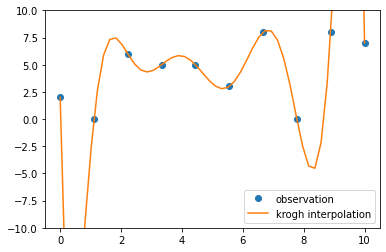

In [2]:
x = np.linspace(0, 10)
y = krogh_interpolate(x_observed, y_observed, x)
plt.plot(x_observed, y_observed, "o", label="observation")
plt.plot(x, y, label="krogh interpolation")
plt.ylim((-10,10))
plt.legend()
plt.show()

In [3]:
class KroghInterpolator(_Interpolator1DWithDerivatives):

    def __init__(self, xi, yi, axis=0):
        _Interpolator1DWithDerivatives.__init__(self, xi, yi, axis)

        self.xi = np.asarray(xi)
        self.yi = self._reshape_yi(yi)
        self.n, self.r = self.yi.shape

        if (deg := self.xi.size) > 30:
            warnings.warn(f"{deg} degrees provided, degrees higher than about"
                          " thirty cause problems with numerical instability "
                          "with 'KroghInterpolator'", stacklevel=2)

        c = np.zeros((self.n+1, self.r), dtype=self.dtype)
        c[0] = self.yi[0]
        Vk = np.zeros((self.n, self.r), dtype=self.dtype)
        for k in range(1, self.n):
            s = 0
            while s <= k and xi[k-s] == xi[k]:
                s += 1
            s -= 1
            Vk[0] = self.yi[k]/float_factorial(s)
            for i in range(k-s):
                if xi[i] == xi[k]:
                    raise ValueError("Elements if `xi` can't be equal.")
                if s == 0:
                    Vk[i+1] = (c[i]-Vk[i])/(xi[i]-xi[k])
                else:
                    Vk[i+1] = (Vk[i+1]-Vk[i])/(xi[i]-xi[k])
            c[k] = Vk[k-s]
        self.c = c

    def _evaluate(self, x):
        pi = 1
        p = np.zeros((len(x), self.r), dtype=self.dtype)
        p += self.c[0,np.newaxis,:]
        for k in range(1, self.n):
            w = x - self.xi[k-1]
            pi = w*pi
            p += pi[:,np.newaxis] * self.c[k]
        return p

    def _evaluate_derivatives(self, x, der=None):
        n = self.n
        r = self.r

        if der is None:
            der = self.n
        pi = np.zeros((n, len(x)))
        w = np.zeros((n, len(x)))
        pi[0] = 1
        p = np.zeros((len(x), self.r), dtype=self.dtype)
        p += self.c[0, np.newaxis, :]

        for k in range(1, n):
            w[k-1] = x - self.xi[k-1]
            pi[k] = w[k-1] * pi[k-1]
            p += pi[k, :, np.newaxis] * self.c[k]

        cn = np.zeros((max(der, n+1), len(x), r), dtype=self.dtype)
        cn[:n+1, :, :] += self.c[:n+1, np.newaxis, :]
        cn[0] = p
        for k in range(1, n):
            for i in range(1, n-k+1):
                pi[i] = w[k+i-1]*pi[i-1] + pi[i]
                cn[k] = cn[k] + pi[i, :, np.newaxis]*cn[k+i]
            cn[k] *= float_factorial(k)

        cn[n, :, :] = 0
        return cn[:der]


NameError: name '_Interpolator1DWithDerivatives' is not defined

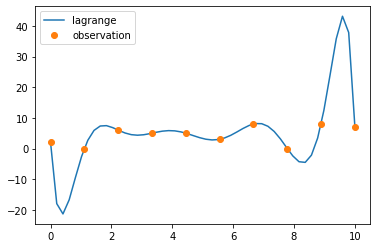

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def L_i(x, x_i):
    numerator = 1
    denominator = 1
    for x_j in x_observed:
        if (x_j != x_i):
            numerator *= (x - x_j)
    for x_j in x_observed:
        if (x_j != x_i):
            denominator *= (x_i - x_j)
    return numerator / denominator 

def lagrange(x):
    L = 0
    for i in range(len(y_observed)):
        L += y_observed[i] * L_i(x, x_observed[i])
    return L


x = np.linspace(0, 10)
w = lagrange(x)
plt.plot(x, w, label='lagrange')
plt.plot(x_observed, y_observed, "o", label="observation")
plt.legend()
plt.show()